# MGT 595 Problem Set 9

# Author: Denglin Wu, Joanna Chen, Adrienne Larson

This problem set explores the role of various factors, such as value and momentum, across asset classes and how a combination of factors performs. It also examines other measures of risk such as higher moments of the distribution and drawdowns.

In order to proceed you need the Microsoft Excel file “Problem_Set9.xls”. This file contains six spreadsheets:

1)	The monthly returns to value and momentum factors (long-short portfolios) for stock selection strategies in the U.S., U.K., Europe, and Japan, country equity index futures, government bonds, currencies (relative to the $US), and commodities.

2)	The monthly returns to the TSMOM factor of Moskowitz, Ooi, and Pedersen (2012), representing time-series momentum.

3)	The monthly returns to the Fama-French factors consisting of RMRF, SMB, HML, and UMD, as well as STR (short-term reversals) and LTREV (long-term reversals).

4)	The monthly returns to the BAB factor of Frazzini and Pedersen (2013), a globally diversified defensive/quality factor related to the work of Novy-Marx (2012) and Asness, Frazzini, and Pedersen (2015), and a global carry factor related to the work of Koijen, Moskowitz, Pedersen, and Vrugt (2015) and Asness, Ilmanen, Israel, and Moskowitz (2014).

5)	The monthly returns to a set of hedge fund strategy indices from Dow Jones/Credit Suisse and HFRI.

*All portfolios except for 5) are long-short portfolios, so there is no need to subtract off the risk-free rate for these. The portfolios in 5) are long-only.

**Also, be careful of the dates for each of these series as they start at different times. You need to make sure you align things up properly.


# Data Processing

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import f
import scipy.stats as stats
import matplotlib.pyplot as plt
import statistics
import math

In [ ]:
#--------------------Read Sheet 1--------------------
stock = pd.read_excel("Problem_Set9.xls", sheet_name="Value and momentum factors", 
                     skiprows=4, index_col=None, usecols="A:I", na_values=-999)
stock = stock.set_index("DATE")

assets = pd.read_excel("Problem_Set9.xls", sheet_name="Value and momentum factors", 
                     skiprows=4, index_col=None, usecols="J:Q", na_values=-999)
assets.index = stock.index

#--------------------Read Sheet 2--------------------
TSMOM = pd.read_excel("Problem_Set9.xls", sheet_name="TSMOM", 
                     skiprows=2, index_col=None, usecols="A:F", na_values=-999)
TSMOM = TSMOM.set_index("DATE")

#--------------------Read Sheet 3--------------------
FF = pd.read_excel("Problem_Set9.xls", sheet_name="Fama-French factors", 
                     index_col=None, usecols="A:H", na_values=-999)
FF["DATE"] = pd.to_datetime(FF["Unnamed: 0"], format="%Y%m")
FF = FF.set_index("DATE")
FF = FF.drop("Unnamed: 0", axis = 1)

#--------------------Read Sheet 4--------------------
CBQ = pd.read_excel("Problem_Set9.xls", sheet_name="Carry, BAB, and Quality", 
                     skiprows=3, index_col=None, usecols="A:D", na_values=-999)
CBQ["DATE"] = pd.to_datetime(CBQ["DATE"], format="%Y%m")
CBQ = CBQ.set_index("DATE")

#--------------------Read Sheet 5--------------------
AMP = pd.read_excel("Problem_Set9.xls", sheet_name="AMP factors", 
                     skiprows=3, index_col=None, usecols="A:D", na_values=-999)
AMP["DATE"] = pd.to_datetime(AMP["DATE"], format="%Y%m%d", errors="coerce")
AMP = AMP.set_index("DATE")

#--------------------Read Sheet 5--------------------
HRFI = pd.read_excel("Problem_Set9.xls", sheet_name="HF indices", 
                     skiprows=1, index_col=None, usecols="A:K", na_values=-999)
HRFI["DATE"] = pd.to_datetime(HRFI["Unnamed: 0"], format="%Y%m")
HRFI = HRFI.set_index("DATE")
HRFI = HRFI.drop("Unnamed: 0", axis = 1)

DJCS = pd.read_excel("Problem_Set9.xls", sheet_name="HF indices", 
                     skiprows=1, index_col=None, usecols="L:V", na_values=-999)
DJCS["DATE"] = pd.to_datetime(DJCS["Unnamed: 11"], format="%Y%m")
DJCS = DJCS.set_index("DATE")
DJCS = DJCS.drop("Unnamed: 11", axis = 1)

# Part 1:  Value and Momentum portfolios



## a)	Compute the mean return, t-stat of mean, Sharpe ratio, skewness, and kurtosis of each value and momentum strategy in each market. Report the confidence interval around the Sharpe ratio (for both the normal distribution and the more general ergodic distribution). Report the percentage of observations exceeding + or – 3 standard deviations.

In [ ]:
# Part a)
stock_mean = pd.Series.tolist(np.mean(stock))
assets_mean = pd.Series.tolist(np.mean(assets))
stock_std = pd.Series.tolist(np.std(stock))
assets_std = pd.Series.tolist(np.std(assets))
stock_count = [526, 526, 413, 527, 413, 502, 413, 502]
assets_count = [465, 465, 443, 443, 395, 395, 527, 527]
stock_skewness = np.ma.getdata(stats.skew(stock, nan_policy='omit'))
assets_skewness = np.ma.getdata(stats.skew(assets, nan_policy='omit'))
stock_kurtosis = np.ma.getdata(stats.kurtosis(stock, nan_policy='omit'))
assets_kurtosis = np.ma.getdata(stats.kurtosis(assets, nan_policy='omit'))
stock_stderr = []
assets_stderr = []
stock_tstats = []
assets_tstats = []
stock_sharpe = []
assets_sharpe = []
stock_NO_CI_upper = []
stock_NO_CI_lower = []
assets_NO_CI_upper = []
assets_NO_CI_lower = []
stock_mu_4 = []
stock_mu_3 = []
for column in stock.columns:
        stock_mu_4.append(np.mean((stock[column] - np.mean(stock[column]))**4))
        stock_mu_3.append(np.mean((stock[column] - np.mean(stock[column]))**3))
assets_mu_4 = []
assets_mu_3 = []
for column in assets.columns:
        assets_mu_4.append(np.mean((assets[column] - np.mean(assets[column]))**4))
        assets_mu_3.append(np.mean((assets[column] - np.mean(assets[column]))**3))
stock_GE_CI_upper = []
stock_GE_CI_lower = []
assets_GE_CI_upper = []
assets_GE_CI_lower = []
for i in range(8):
    stock_stderr.append(stock_std[i] / np.sqrt(stock_count[i]))
    assets_stderr.append(assets_std[i] / np.sqrt(assets_count[i]))
    stock_tstats.append(stock_mean[i] / stock_stderr[i])
    assets_tstats.append(assets_mean[i] / assets_stderr[i])
    stock_sharpe.append(stock_mean[i] / stock_std[i] * np.sqrt(12))
    assets_sharpe.append(assets_mean[i] / assets_std[i] * np.sqrt(12))
    stock_NO_CI_upper.append(stock_sharpe[i] + 1.96 * np.sqrt((1/(stock_count[i]-1)) * (1 + 0.5 * stock_sharpe[i]**2)))
    stock_NO_CI_lower.append(stock_sharpe[i] - 1.96 * np.sqrt((1/(stock_count[i]-1)) * (1 + 0.5 * stock_sharpe[i]**2)))
    assets_NO_CI_upper.append(assets_sharpe[i] + 1.96 * np.sqrt((1/(assets_count[i]-1)) * (1 + 0.5 * assets_sharpe[i]**2)))
    assets_NO_CI_lower.append(assets_sharpe[i] - 1.96 * np.sqrt((1/(assets_count[i]-1)) * (1 + 0.5 * assets_sharpe[i]**2))) 
    stock_GE_CI_upper.append(stock_sharpe[i] + 1.96 * np.sqrt((1/(stock_count[i]-1)) * (1 + 0.25 * stock_sharpe[i]**2) * (stock_mu_4[i] / (stock_std[i]**4) - 1) - stock_sharpe[i] * stock_mu_3[i] / stock_std[i]**3))
    stock_GE_CI_lower.append(stock_sharpe[i] - 1.96 * np.sqrt((1/(stock_count[i]-1)) * (1 + 0.25 * stock_sharpe[i]**2) * (stock_mu_4[i] / (stock_std[i]**4) - 1) - stock_sharpe[i] * stock_mu_3[i] / stock_std[i]**3))
    assets_GE_CI_upper.append(assets_sharpe[i] + 1.96 * np.sqrt((1/(assets_count[i]-1)) * (1 + 0.25 * assets_sharpe[i]**2) * (assets_mu_4[i] / (assets_std[i]**4) - 1) - assets_sharpe[i] * assets_mu_3[i] / assets_std[i]**3))
    assets_GE_CI_lower.append(assets_sharpe[i] - 1.96 * np.sqrt((1/(assets_count[i]-1)) * (1 + 0.25 * assets_sharpe[i]**2) * (assets_mu_4[i] / (assets_std[i]**4) - 1) - assets_sharpe[i] * assets_mu_3[i] / assets_std[i]**3)) 
    
# Generate summary table for stock selections
stock_summary = {"Stock Mean": stock_mean, "T-Stat of Mean": stock_tstats, "Sharpe Ratio": stock_sharpe, \
                 "Skewness": stock_skewness, "Kurtosis": stock_kurtosis, "Norm_CI_Upper": stock_NO_CI_upper, \
                 "Norm_CI_Lower": stock_NO_CI_lower, "GE_CI_Upper": stock_GE_CI_upper, "GE_CI_Lower": stock_GE_CI_lower}
stock_summary = pd.DataFrame(stock_summary)
stock_summary.index = ['US-Value', 'US-MOM', 'UK-Value', 'UK-MOM', 'EU-Value', 'EU-MOM', 'JP-Value', 'JP-MOM']
# Generate summary table for assets allocations
assets_summary = {"Asset Mean": assets_mean, "T-Stat of Mean": assets_tstats, "Sharpe Ratio": assets_sharpe, \
                 "Skewness": assets_skewness, "Kurtosis": assets_kurtosis, "Norm_CI_Upper": assets_NO_CI_upper, \
                 "Norm_CI_Lower": assets_NO_CI_lower, "GE_CI_Upper": assets_GE_CI_upper, "GE_CI_Lower": assets_GE_CI_lower}
assets_summary = pd.DataFrame(assets_summary)
assets_summary.index = ['Ind-Value', 'Ind-MOM', 'Cur-Value', 'Cur-MOM', 'FI-Value', 'FI-MOM', 'Comm-Value', 'Comm-MOM']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in sqrt


In [ ]:
stock_summary

,Stock Mean,T-Stat of Mean,Sharpe Ratio,Skewness,Kurtosis,Norm_CI_Upper,Norm_CI_Lower,GE_CI_Upper,GE_CI_Lower
US-Value,0.002706,1.419612,0.214421,-0.288223,12.712935,0.300940,0.127902,0.802904,-0.374062
US-MOM,0.006080,3.016839,0.455669,-0.148017,7.449326,0.545541,0.365797,1.031722,-0.120383
UK-Value,0.002796,1.391193,0.237139,-0.399381,9.924212,0.335049,0.139229,0.927487,-0.453209
UK-MOM,0.006773,3.607350,0.544344,-0.477077,5.036772,0.635916,0.452772,1.570424,-0.481736
EU-Value,0.002604,1.750620,0.298406,-0.086157,8.315531,0.397094,0.199717,0.742358,-0.145546
EU-MOM,0.007499,4.477222,0.692225,-0.841531,5.349897,0.789719,0.594732,2.209114,-0.824664
JP-Value,0.007581,3.813353,0.650014,-0.094355,6.277812,0.756288,0.543740,1.216539,0.083488
JP-MOM,0.001965,0.946952,0.146409,-0.505646,2.893654,0.234443,0.058374,0.713966,-0.421149


In [ ]:
assets_summary

,Asset Mean,T-Stat of Mean,Sharpe Ratio,Skewness,Kurtosis,Norm_CI_Upper,Norm_CI_Lower,GE_CI_Upper,GE_CI_Lower
Ind-Value,0.002932,2.367805,0.380373,0.072141,1.091582,0.474598,0.286149,NaN,NaN
Ind-MOM,0.005106,3.405563,0.547083,-0.297464,1.345295,0.644645,0.449521,1.356368,-0.262202
Cur-Value,0.002589,2.209160,0.363593,0.181300,2.801452,0.459853,0.267334,NaN,NaN
Cur-MOM,0.002407,1.920232,0.316040,-0.524459,1.385690,0.411568,0.220513,1.132684,-0.500604
FI-Value,0.000678,0.831235,0.144882,1.479241,11.277878,0.244143,0.045622,NaN,NaN
FI-MOM,0.000534,0.751510,0.130987,0.110586,2.905329,0.230153,0.031821,NaN,NaN
Comm-Value,0.005384,1.880411,0.283751,0.036460,1.529771,0.370915,0.196588,NaN,NaN
Comm-MOM,0.009360,3.447063,0.520157,0.139837,2.440964,0.611215,0.429100,NaN,NaN


## b)	Can you statistically reject whether the value premia are equal across all markets and asset classes?  For just the equity markets?  Can you do the same for the momentum premia?

From the results above, we can reject that the value premia are equal across all markets and assets classes. This is due to the unusually high value premia from the Japan stocks, and the unusually low value premia from Fixed Income and Commodities. We do see, however, that there are substantially more similarities than differences.

For just the Equity Markets, because of the unusually high value from the Japan market, we again reject that the value premia are the same across market, but recognize that the observation has more similarities than differences. Note that, as we know that value and momentum are complementary to each other, the Japan market still shows the same relationship, and its momentum premium seems to be in line with other markets' value premia.

For momentum premia, we observe the same trend. The momentum premia are similar across different markets and asset classes, with notable exception again from the Japan equity, Fixed Income, and Commodities. Looking at just the equity market, the momentum premium from the Japanese market is unusually low comparing to other markets, but again still seems to complement its value premium.

## c)	Compute the maximum drawdown of each strategy, 
**which is the most negative return achieved on the strategy over its life, defined for each strategy as**

**MDD(T) = [trough value – peak value (prior to the trough)]/peak value**

**Or, equivalently**

**MDD(T) = (L-P)/P
P = peak value before largest drop; L = lowest value before new high established.**

**Also, report the length of the period of the maximum drawdown for each strategy (i.e., “how long the pain lasts”).**

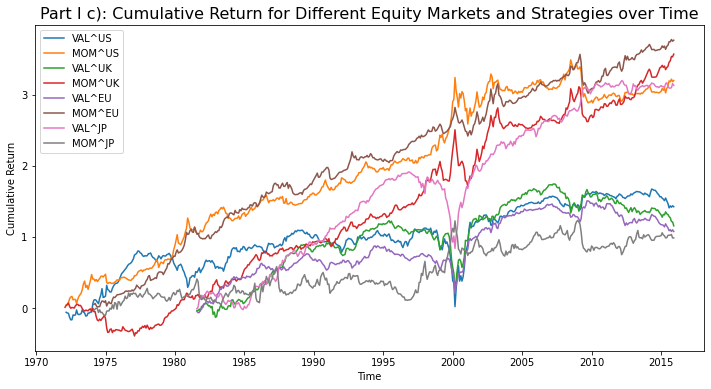

In [ ]:
stock_cum = stock.cumsum(axis=0)
fig=plt.figure(figsize=(12,6))
plt.plot(stock_cum.index, stock_cum)
plt.xlabel('Time')
plt.ylabel('Cumulative Return');
plt.title('Part I c): Cumulative Return for Different Equity Markets and Strategies over Time', fontsize=16)
plt.legend(stock_cum.columns)

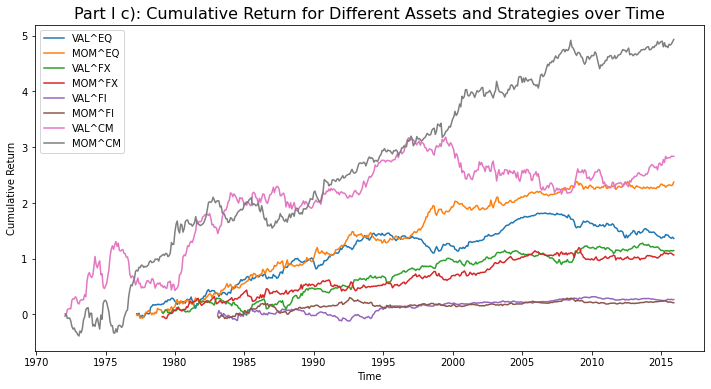

In [ ]:
assets_cum = assets.cumsum(axis=0)
fig=plt.figure(figsize=(12,6))
plt.plot(assets_cum.index, assets_cum)
plt.xlabel('Time')
plt.ylabel('Cumulative Return');
plt.title('Part I c): Cumulative Return for Different Assets and Strategies over Time', fontsize=16)
plt.legend(assets_cum.columns)

To calculate the peak, drought, maximum drawdown, and the length of the maximum drawdown, we can look at the equity market and different assets classes separately.

In [ ]:
stock_peak = []
stock_trought = []
stock_trought_length = []
for column in stock_cum.columns:
    temp_peak = 0
    pre_peak = 0
    temp_trought = 0
    max_trought = 0
    temp_trought_length = 0
    max_trought_length = 0
    previous_nan = True 
    for index in stock_cum.index:
        if math.isnan(stock_cum[column][index]):
            continue
        if previous_nan == True:
            previous_nan = False
            if stock[column][index] < 0:
                temp_trought_length = temp_trought_length + 1
                temp_trought = stock_cum[column][index] - temp_peak
            else:
                temp_peak = stock[column][index]
        if previous_nan == False:
            if stock_cum[column][index] < temp_peak:
                temp_trought_length = temp_trought_length + 1
                if stock_cum[column][index] - temp_peak < temp_trought:
                    temp_trought = stock_cum[column][index] - temp_peak
            else:
                #pre_peak = stock_cum[column][index]
                if temp_trought < max_trought:
                    pre_peak = temp_peak
                    max_trought = temp_trought
                    max_trought_length = temp_trought_length
                temp_peak = stock_cum[column][index]
                temp_trought_length = 0
    stock_peak.append(pre_peak)
    stock_trought.append(max_trought)
    stock_trought_length.append(max_trought_length)

sp = pd.DataFrame(stock_peak)
st = pd.DataFrame(stock_trought)
stl = pd.DataFrame(stock_trought_length)
stock_MDD = ((sp + st) - sp) / sp
stock_MDD = stock_MDD.iloc[:, 0].values.tolist()
# Generate trought summary
stock_trought_summary = {"Trought": stock_trought, "Previous Peak": stock_peak, \
                         "Max Drawdown": stock_MDD, "MDD Length (month)": stock_trought_length}
stock_trought_summary = pd.DataFrame.from_dict(stock_trought_summary)
stock_trought_summary.index = ['US-Value', 'US-MOM', 'UK-Value', 'UK-MOM', 'EU-Value', 'EU-MOM', 'JP-Value', 'JP-MOM']
stock_trought_summary

,Trought,Previous Peak,Max Drawdown,MDD Length (month)
US-Value,-1.104551,1.123695,-0.982964,38
US-MOM,-0.653240,3.239881,-0.201625,30
UK-Value,-1.010055,1.227383,-0.822934,72
UK-MOM,-0.794760,2.505692,-0.317182,28
EU-Value,-0.664679,0.872737,-0.761603,80
EU-MOM,-0.546165,3.565655,-0.153174,49
JP-Value,-1.075491,1.913280,-0.562119,56
JP-MOM,-0.495156,1.224957,-0.404224,105


In [ ]:
assets_peak = []
assets_trought = []
assets_trought_length = []
for column in assets_cum.columns:
    temp_peak = 0
    pre_peak = 0
    temp_trought = 0
    max_trought = 0
    temp_trought_length = 0
    max_trought_length = 0
    previous_nan = True 
    for index in assets_cum.index:
        if math.isnan(assets_cum[column][index]):
            continue
        if previous_nan == True:
            previous_nan = False
            if assets[column][index] < 0:
                temp_trought_length = temp_trought_length + 1
                temp_trought = assets_cum[column][index] - temp_peak
            else:
                temp_peak = assets[column][index]
        if previous_nan == False:
            if assets_cum[column][index] < temp_peak:
                temp_trought_length = temp_trought_length + 1
                if assets_cum[column][index] - temp_peak < temp_trought:
                    temp_trought = assets_cum[column][index] - temp_peak
            else:
                #pre_peak = stock_cum[column][index]
                if temp_trought < max_trought:
                    pre_peak = temp_peak
                    max_trought = temp_trought
                    max_trought_length = temp_trought_length
                temp_peak = assets_cum[column][index]
                temp_trought_length = 0
    assets_peak.append(pre_peak)
    assets_trought.append(max_trought)
    assets_trought_length.append(max_trought_length)
    
ap = pd.DataFrame(assets_peak)
at = pd.DataFrame(assets_trought)
atl = pd.DataFrame(assets_trought_length)
assets_MDD = ((ap + at) - ap) / ap
assets_MDD = assets_MDD.iloc[:, 0].values.tolist()
# Generate trought summary
assets_trought_summary = {"Trought": assets_trought, "Previous Peak": assets_peak, \
                         "Max Drawdown": assets_MDD, "MDD Length (month)": assets_trought_length}
assets_trought_summary = pd.DataFrame(assets_trought_summary)
assets_trought_summary.index = ['Ind-Value', 'Ind-MOM', 'Cur-Value', 'Cur-MOM', 'FI-Value', 'FI-MOM', 'Comm-Value', 'Comm-MOM']
assets_trought_summary

,Trought,Previous Peak,Max Drawdown,MDD Length (month)
Ind-Value,-0.357471,1.458975,-0.245015,95
Ind-MOM,-0.204898,1.486936,-0.137799,52
Cur-Value,-0.306311,0.294425,-1.040372,65
Cur-MOM,-0.199153,0.619977,-0.321227,69
FI-Value,-0.236446,0.118479,-1.995683,116
FI-MOM,-0.190809,0.196722,-0.969943,65
Comm-Value,-0.876682,1.308053,-0.670219,64
Comm-MOM,-0.590020,0.254695,-2.316570,19


## d)	Calculate a global value factor and separately a global momentum factor across all markets and asset classes by weighting each market’s factor by the inverse of its in-sample volatility (standard deviation) estimate. We will call these VALeverywhere and MOMeverywhere, respectively. Compute the mean return, t-stat of mean, Sharpe ratio, skewness, kurtosis, and maximum drawdowns of these two global factors.  Also, report the confidence interval around the Sharpe ratio (for both the normal distribution and the more general ergodic distribution).  Report the percentage of observations exceeding + or – 3 standard deviations.

In [ ]:
VAL_columns = ['VAL^US', 'VAL^UK', 'VAL^EU', 'VAL^JP', 'VAL^EQ', 'VAL^FX', 'VAL^FI', 'VAL^CM']
MOM_columns = ['MOM^US', 'MOM^UK', 'MOM^EU', 'MOM^JP', 'MOM^EQ', 'MOM^FX', 'MOM^FI', 'MOM^CM']
ALL = pd.concat([stock, assets], axis=1)
# VAL Factor
VALeverywhere = ALL[VAL_columns]
VAL_std_inv = 1 / np.std(VALeverywhere)
VAL_weight = VAL_std_inv / np.sum(VAL_std_inv)
VALeverywhere['VAL Factor'] = VALeverywhere[VAL_columns].mul(VAL_weight).sum(1)
VAL_mean = np.mean(VALeverywhere['VAL Factor'])
VAL_std = np.std(VALeverywhere['VAL Factor'])
VAL_stderr = VAL_std / np.sqrt(527)
VAL_tstats = VAL_mean / VAL_stderr
VAL_skewness = np.ma.getdata(stats.skew(VALeverywhere['VAL Factor'], nan_policy='omit'))
VAL_kurtosis = np.ma.getdata(stats.kurtosis(VALeverywhere['VAL Factor'], nan_policy='omit'))
VAL_sharpe = VAL_mean / VAL_std * np.sqrt(12)
VAL_NO_CI_upper = VAL_sharpe + 1.96 * np.sqrt((1/(527-1)) * (1 + 0.5 * VAL_sharpe**2))
VAL_NO_CI_lower = VAL_sharpe - 1.96 * np.sqrt((1/(527-1)) * (1 + 0.5 * VAL_sharpe**2))
VAL_mu_4 = np.mean((VALeverywhere['VAL Factor'] - np.mean(VALeverywhere['VAL Factor']))**4)
VAL_mu_3 = np.mean((VALeverywhere['VAL Factor'] - np.mean(VALeverywhere['VAL Factor']))**3)
VAL_GE_CI_upper = VAL_sharpe + 1.96 * np.sqrt((1/(527-1)) * (1 + 0.25 * VAL_sharpe**2) * (VAL_mu_4 / (VAL_std**4) - 1) - VAL_sharpe * VAL_mu_3 / VAL_std**3)
VAL_GE_CI_lower = VAL_sharpe - 1.96 * np.sqrt((1/(527-1)) * (1 + 0.25 * VAL_sharpe**2) * (VAL_mu_4 / (VAL_std**4) - 1) - VAL_sharpe * VAL_mu_3 / VAL_std**3)
VAL_Factor = VALeverywhere['VAL Factor']
VAL_Factor_cum = VAL_Factor.cumsum(axis=0)
temp_peak = 0
pre_peak = 0
temp_trought = 0
max_trought = 0
temp_trought_length = 0
max_trought_length = 0
previous_nan = True 
for index in VAL_Factor_cum.index:
    if math.isnan(VAL_Factor[index]):
        continue
    if previous_nan == True:
        previous_nan = False
        if VAL_Factor[index] < 0:
            temp_trought_length = temp_trought_length + 1
            temp_trought = VAL_Factor_cum[index] - temp_peak
        else:
            temp_peak = VAL_Factor[index]
    if previous_nan == False:
        if VAL_Factor_cum[index] < temp_peak:
            temp_trought_length = temp_trought_length + 1
            if VAL_Factor_cum[index] - temp_peak < temp_trought:
                temp_trought = VAL_Factor_cum[index] - temp_peak
        else:
            if temp_trought < max_trought:
                pre_peak = temp_peak
                max_trought = temp_trought
                max_trought_length = temp_trought_length
            temp_peak = VAL_Factor_cum[index]
            temp_trought_length = 0
VAL_MDD = ((pre_peak + max_trought) - pre_peak) / pre_peak

# MOM Factor
MOMeverywhere = ALL[MOM_columns]
MOM_std_inv = 1 / np.std(MOMeverywhere)
MOM_weight = MOM_std_inv / np.sum(MOM_std_inv)
MOMeverywhere['MOM Factor'] = MOMeverywhere[MOM_columns].mul(MOM_weight).sum(1)
MOM_mean = np.mean(MOMeverywhere['MOM Factor'])
MOM_std = np.std(MOMeverywhere['MOM Factor'])
MOM_stderr = MOM_std / np.sqrt(527)
MOM_tstats = MOM_mean / MOM_stderr
MOM_skewness = np.ma.getdata(stats.skew(MOMeverywhere['MOM Factor'], nan_policy='omit'))
MOM_kurtosis = np.ma.getdata(stats.kurtosis(MOMeverywhere['MOM Factor'], nan_policy='omit'))
MOM_sharpe = MOM_mean / MOM_std * np.sqrt(12)
MOM_NO_CI_upper = MOM_sharpe + 1.96 * np.sqrt((1/(527-1)) * (1 + 0.5 * MOM_sharpe**2))
MOM_NO_CI_lower = MOM_sharpe - 1.96 * np.sqrt((1/(527-1)) * (1 + 0.5 * MOM_sharpe**2))
MOM_mu_4 = np.mean((MOMeverywhere['MOM Factor'] - np.mean(MOMeverywhere['MOM Factor']))**4)
MOM_mu_3 = np.mean((MOMeverywhere['MOM Factor'] - np.mean(MOMeverywhere['MOM Factor']))**3)
MOM_GE_CI_upper = MOM_sharpe + 1.96 * np.sqrt((1/(527-1)) * (1 + 0.25 * MOM_sharpe**2) * (MOM_mu_4 / (MOM_std**4) - 1) - MOM_sharpe * MOM_mu_3 / MOM_std**3)
MOM_GE_CI_lower = MOM_sharpe - 1.96 * np.sqrt((1/(527-1)) * (1 + 0.25 * MOM_sharpe**2) * (MOM_mu_4 / (MOM_std**4) - 1) - MOM_sharpe * MOM_mu_3 / MOM_std**3)
MOM_Factor = MOMeverywhere['MOM Factor']
MOM_Factor_cum = MOM_Factor.cumsum(axis=0)
temp_peak = 0
pre_peak = 0
temp_trought = 0
max_trought = 0
temp_trought_length = 0
max_trought_length = 0
previous_nan = True 
for index in MOM_Factor_cum.index:
    if math.isnan(MOM_Factor[index]):
        continue
    if previous_nan == True:
        previous_nan = False
        if MOM_Factor[index] < 0:
            temp_trought_length = temp_trought_length + 1
            temp_trought = MOM_Factor_cum[index] - temp_peak
        else:
            temp_peak = MOM_Factor[index]
    if previous_nan == False:
        if MOM_Factor_cum[index] < temp_peak:
            temp_trought_length = temp_trought_length + 1
            if MOM_Factor_cum[index] - temp_peak < temp_trought:
                temp_trought = MOM_Factor_cum[index] - temp_peak
        else:
            if temp_trought < max_trought:
                pre_peak = temp_peak
                max_trought = temp_trought
                max_trought_length = temp_trought_length
            temp_peak = MOM_Factor_cum[index]
            temp_trought_length = 0
MOM_MDD = ((pre_peak + max_trought) - pre_peak) / pre_peak

Factor_mean = [VAL_mean, MOM_mean]
Factor_tstats = [VAL_tstats, MOM_tstats]
Factor_sharpe = [VAL_sharpe, MOM_sharpe]
Factor_skewness = [VAL_skewness, MOM_skewness]
Factor_kurtosis = [VAL_kurtosis, MOM_kurtosis]
Factor_NO_CI_upper = [VAL_NO_CI_upper, MOM_NO_CI_upper]
Factor_NO_CI_lower = [VAL_NO_CI_lower, MOM_NO_CI_lower]
Factor_GE_CI_upper = [VAL_GE_CI_upper, MOM_GE_CI_upper]
Factor_GE_CI_lower = [VAL_GE_CI_lower, MOM_GE_CI_lower]
Factor_MDD = [VAL_MDD, MOM_MDD]
Factor_summary = {"Factor Mean": Factor_mean, "T-Stat of Mean": Factor_tstats, "Sharpe Ratio": Factor_sharpe, \
                 "Skewness": Factor_skewness, "Kurtosis": Factor_kurtosis, "Norm_CI_Upper": Factor_NO_CI_upper, \
                 "Norm_CI_Lower": Factor_NO_CI_lower, "GE_CI_Upper": Factor_GE_CI_upper, "GE_CI_Lower": Factor_GE_CI_lower, \
                 "MDD": Factor_MDD}
Factor_summary = pd.DataFrame(Factor_summary)
Factor_summary.index = ['VAL Factor', 'MOM Factor']
Factor_summary

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Factor Mean,T-Stat of Mean,Sharpe Ratio,Skewness,Kurtosis,Norm_CI_Upper,Norm_CI_Lower,GE_CI_Upper,GE_CI_Lower,MDD
VAL Factor,0.002416,3.828158,0.577664,-0.6206776505694901,11.88101838637715,0.669978,0.485349,1.797178,-0.641851,-0.352146
MOM Factor,0.003673,4.746095,0.716179,-0.4211905886199857,3.070577208432274,0.811973,0.620386,1.811895,-0.379536,-0.118186


##e)	Calculate a 50-50 combination of value+momentum for each market/asset class, which is a 50-50 weighting of the value and momentum factors within each market and asset class.  Compute the mean return, t-stat of mean, Sharpe ratio, skewness, kurtosis, and maximum drawdown of each val-mom combo factor.  Also, report the confidence interval around the Sharpe ratio (for both the normal distribution and the more general ergodic distribution).  Report the percentage of observations exceeding + or – 3 standard deviations.

In [ ]:
US_EQ = stock['VAL^US'] / 2 + stock['MOM^US'] / 2
UK_EQ = stock['VAL^UK'] / 2 + stock['MOM^UK'] / 2
EU_EQ = stock['VAL^EU'] / 2  + stock['MOM^EU'] / 2 
JP_EQ = stock['VAL^JP'] / 2  + stock['MOM^JP'] / 2 

EQ = assets['VAL^EQ'] / 2  + assets['MOM^EQ'] / 2 
FX = assets['VAL^FX'] / 2  + assets['MOM^FX'] / 2 
FI = assets['VAL^FI'] / 2  + assets['MOM^FI'] / 2 
CM = assets['VAL^CM'] / 2  + assets['MOM^CM'] / 2 

VALMOM = pd.concat([US_EQ, UK_EQ, EU_EQ, JP_EQ, EQ, FX, FI, CM], axis=1)
VALMOM.columns = ['US Equity', 'UK Equity', 'EU Equity', 'JP Equity', 'EQ Indices', 'Currencies', 'Fixed Income', 'Commodities']

VALMOM_mean = pd.Series.tolist(np.mean(VALMOM))
VALMOM_std = pd.Series.tolist(np.std(VALMOM))
VALMOM_count = [526, 527, 502, 502, 465, 443, 395, 527]
VALMOM_skewness = np.ma.getdata(stats.skew(VALMOM, nan_policy='omit'))
VALMOM_kurtosis = np.ma.getdata(stats.kurtosis(VALMOM, nan_policy='omit'))
VALMOM_stderr = []
VALMOM_tstats = []
VALMOM_sharpe = []
VALMOM_NO_CI_upper = []
VALMOM_NO_CI_lower = []
VALMOM_GE_CI_upper = []
VALMOM_GE_CI_lower = []
for i in range(8):
    VALMOM_stderr.append(VALMOM_std[i] / np.sqrt(VALMOM_count[i]))
    VALMOM_tstats.append(VALMOM_mean[i] / VALMOM_stderr[i])
    VALMOM_sharpe.append(stock_mean[i] / stock_std[i] * np.sqrt(12))
    VALMOM_NO_CI_upper.append(VALMOM_sharpe[i] + 1.96 * np.sqrt((1/(VALMOM_count[i]-1)) * (1 + 0.5 * VALMOM_sharpe[i]**2)))
    VALMOM_NO_CI_lower.append(VALMOM_sharpe[i] - 1.96 * np.sqrt((1/(VALMOM_count[i]-1)) * (1 + 0.5 * VALMOM_sharpe[i]**2)))
    VALMOM_GE_CI_upper.append(VALMOM_sharpe[i] + 1.96 * np.sqrt((1/(VALMOM_count[i]-1)) * (1 + 0.25 * VALMOM_sharpe[i]**2) * (VALMOM_kurtosis[i] - 1) - VALMOM_sharpe[i] * VALMOM_skewness[i]))
    VALMOM_GE_CI_lower.append(VALMOM_sharpe[i] - 1.96 * np.sqrt((1/(VALMOM_count[i]-1)) * (1 + 0.25 * VALMOM_sharpe[i]**2) * (VALMOM_kurtosis[i] - 1) - VALMOM_sharpe[i] * VALMOM_skewness[i]))

VALMOM_summary = {"Mean": VALMOM_mean, "T-Stat of Mean": VALMOM_tstats, "Sharpe Ratio": VALMOM_sharpe, \
                 "Skewness": VALMOM_skewness, "Kurtosis": VALMOM_kurtosis, "Norm_CI_Upper": VALMOM_NO_CI_upper, \
                 "Norm_CI_Lower": VALMOM_NO_CI_lower, "GE_CI_Upper": VALMOM_GE_CI_upper, "GE_CI_Lower": VALMOM_GE_CI_lower}
VALMOM_summary = pd.DataFrame(VALMOM_summary)
VALMOM_summary.index = ['US Equity', 'UK Equity', 'EU Equity', 'JP Equity', 'EQ Indices', 'Currencies', 'Fixed Income', 'Commodities']
VALMOM_summary

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in sqrt


,Mean,T-Stat of Mean,Sharpe Ratio,Skewness,Kurtosis,Norm_CI_Upper,Norm_CI_Lower,GE_CI_Upper,GE_CI_Lower
US Equity,0.004393,5.281400,0.214421,0.745147,11.325045,0.300940,0.127902,NaN,NaN
UK Equity,0.005508,6.843261,0.455669,0.302597,2.525228,0.545456,0.365883,NaN,NaN
EU Equity,0.004541,6.037894,0.237139,0.180523,1.842584,0.325928,0.148350,NaN,NaN
JP Equity,0.004565,5.369999,0.544344,-0.027842,3.250102,0.638173,0.450515,0.821388,0.267301
EQ Indices,0.004019,5.282681,0.298406,0.066384,0.975679,0.391400,0.205412,NaN,NaN
Currencies,0.002498,3.897961,0.692225,0.953161,8.043813,0.796022,0.588429,NaN,NaN
Fixed Income,0.000606,1.275825,0.650014,1.419801,11.516704,0.758688,0.541340,NaN,NaN
Commodities,0.007372,5.189772,0.146409,0.258666,1.271591,0.232325,0.060492,NaN,NaN


##f)	Now, calculate a value+momentum factor across all markets and asset classes by weighting each market’s val-mom combo factor by the inverse of its in-sample volatility (standard deviation) estimate.  Compute the mean return, t-stat of mean, Sharpe ratio, skewness, kurtosis, and maximum drawdown of this factor. Also, report the confidence interval around the Sharpe ratio (for both the normal distribution and the more general ergodic distribution).  Report the percentage of observations exceeding + or – 3 standard deviations.

In [ ]:
AMAA_std_inv = 1 / np.std(VALMOM)
AMAA_weight = AMAA_std_inv / np.sum(AMAA_std_inv)
AMAA_Factor = VALMOM.mul(AMAA_weight).sum(1)
AMAA_Factor_cum = AMAA_Factor.cumsum(axis=0)
#fig=plt.figure(figsize=(12,6))
#plt.plot(AMAA_Factor_cum.index, AMAA_Factor_cum)
AMAA_mean = np.mean(AMAA_Factor)
AMAA_std = np.std(AMAA_Factor)
AMAA_skewness = stats.skew(AMAA_Factor, nan_policy='omit')
AMAA_kurtosis = stats.kurtosis(AMAA_Factor, nan_policy='omit')
AMAA_stderr = AMAA_std / np.sqrt(len(AMAA_Factor))
AMAA_tstats = AMAA_mean / AMAA_stderr
AMAA_sharpe = AMAA_mean / AMAA_std * np.sqrt(12)
AMAA_NO_CI_upper = AMAA_sharpe + 1.96 * np.sqrt((1/(len(AMAA_Factor)-1)) * (1 + 0.5 * AMAA_sharpe**2))
AMAA_NO_CI_lower = AMAA_sharpe - 1.96 * np.sqrt((1/(len(AMAA_Factor)-1)) * (1 + 0.5 * AMAA_sharpe**2))
AMAA_GE_CI_upper = AMAA_sharpe + 1.96 * np.sqrt((1/(len(AMAA_Factor)-1)) * (1 + 0.25 * AMAA_sharpe**2) * (AMAA_kurtosis - 1) - AMAA_sharpe * AMAA_skewness)
AMAA_GE_CI_lower = AMAA_sharpe - 1.96 * np.sqrt((1/(len(AMAA_Factor)-1)) * (1 + 0.25 * AMAA_sharpe**2) * (AMAA_kurtosis - 1) - AMAA_sharpe * AMAA_skewness)

temp_peak = 0
pre_peak = 0
temp_trought = 0
max_trought = 0
temp_trought_length = 0
max_trought_length = 0
previous_nan = True 
for index in AMAA_Factor_cum.index:
    if math.isnan(AMAA_Factor[index]):
        continue
    if previous_nan == True:
        previous_nan = False
        if AMAA_Factor[index] < 0:
            temp_trought_length = temp_trought_length + 1
            temp_trought = AMAA_Factor_cum[index] - temp_peak
        else:
            temp_peak = AMAA_Factor[index]
    if previous_nan == False:
        if AMAA_Factor_cum[index] < temp_peak:
            temp_trought_length = temp_trought_length + 1
            if AMAA_Factor_cum[index] - temp_peak < temp_trought:
                temp_trought = AMAA_Factor_cum[index] - temp_peak
        else:
            if temp_trought < max_trought:
                pre_peak = temp_peak
                max_trought = temp_trought
                max_trought_length = temp_trought_length
            temp_peak = AMAA_Factor_cum[index]
            temp_trought_length = 0
AMAA_MDD = ((pre_peak + max_trought) - pre_peak) / pre_peak

print('For Value + Momentum Factor:')
print('Mean (Annaulized) = ', round(AMAA_mean*12, 2))
print('T-stat of mean = ', round(AMAA_tstats, 2))
print('Sharpe Ratio', round(AMAA_sharpe, 2))
print('With Normal Distribution, the CI for Sharpe Ratio is [', round(AMAA_NO_CI_lower, 2), ", ", round(AMAA_NO_CI_upper, 2), "]")
print('With General Distribution, the CI for Sharpe Ratio is [', round(AMAA_GE_CI_lower, 2), ", ", round(AMAA_GE_CI_upper, 2), "]")
print('Skewness = ', round(AMAA_skewness, 2))
print('Kurtosis = ', round(AMAA_kurtosis, 2))
print('Maximum Drawdown = ', round(AMAA_MDD, 2))

For Value + Momentum Factor:
Mean (Annaulized) =  0.04
T-stat of mean =  9.51
Sharpe Ratio 1.44
With Normal Distribution, the CI for Sharpe Ratio is [ 1.31 ,  1.56 ]
With General Distribution, the CI for Sharpe Ratio is [ nan ,  nan ]
Skewness =  0.55
Kurtosis =  4.09
Maximum Drawdown =  -0.04


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sqrt


## g)	Can you comment on the benefits of diversification from combining across asset classes?  What about from combining two factors (value and momentum)?  Where are the biggest diversification benefits, from asset class diversification or from factor diversification in this case?

Diversification from combining across asset classes allows you to have more constant and stable returns and to be able to survive conditions that have poor effects on some asset classes but not others.

With diversification you do not lose entirely when a few asset classes are poorly affected, because your other asset classes could be performing better. This is especially true if they have a negative covariance or are negatively correlated to the other asset classes. Combining asset classes overall can also have the benefits of economic power from the combined asset class portfolios. Noise is also reduced by the statistical power of both the combined portfolio. 

Combining two factors, such as value and momentum, also allows you to do well when there are conditions that affect one factor but not the other. If your portfolio only had value and then value hurts your portfolio, you would do poorly. However, with momentum in your portfolio as well, your portfolio could still fair relatively well. A 50/50 combination of value and momentum usually has a higher Sharpe ratio than either individually Furthermore, value and momentum are negatively correlated so a combination of both lessens the risk of the two.

## h)	What do the weights of the in-sample tangency portfolio of all the value and momentum factors look like across markets and asset classes?  Plot the efficient frontier of all value and momentum factors and include on the graph the individual value and momentum factors as well as the 50-50 combination of them. 

In [ ]:
sheet1 = pd.read_excel("Problem_Set9.xls", sheet_name="Value and momentum factors", skiprows=4, index_col=None, usecols="A:Q", na_values=-999)
sheet1 = sheet1.set_index("DATE")
R = sheet1.mean()
V = sheet1.cov()
V_inv = np.linalg.inv(V.values)
ones = np.transpose([1]*len(sheet1.columns.tolist()))
onesT = np.transpose(ones)
# Tangency Portfolio
num = V_inv @ R
denom = onesT @ V_inv @ R
weight_tang = num / denom
Tan = sheet1 @ weight_tang
Tan_SD = Tan.std()
Tan_Mean = Tan.mean()
# MVP
num = V_inv @ ones
denom = onesT @ V_inv @ ones
weight_MVP = num / denom
MVP = sheet1 @ weight_MVP
MVP_SD = MVP.std()
MVP_Mean = MVP.mean()

print(weight_tang)

[-0.01728366  0.02646037  0.05956567  0.08728543  0.11187191  0.06833073
  0.12238075  0.06674135  0.08674113  0.04480799  0.09824578  0.05678028
  0.08838437  0.00865844  0.04331059  0.04771886]


In general, the tangency portfolio of all the value and momentum factors again have more similarities than differences, especially within the value factors and momentum factors group separately.

The fit coefficients are a = 7.5550, b = -3.2398 c = 0.9704
       2
7.555 x - 3.24 x + 0.9704


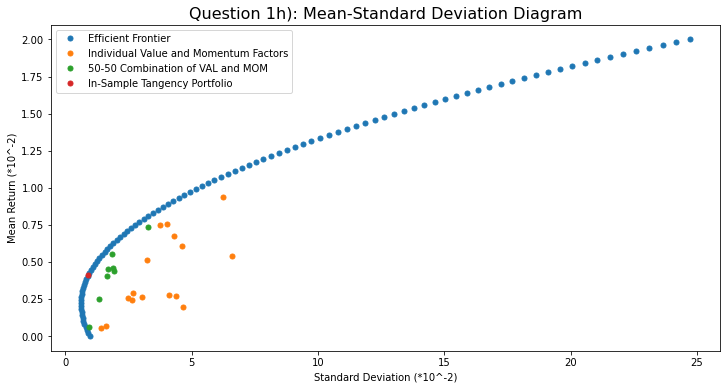

In [ ]:
df = pd.DataFrame({'x':[MVP_SD*100, Tan_SD*100, Tan_SD*100], 
                  'y':[MVP_Mean*100, Tan_Mean*100, 100*(Tan_Mean - 2*(Tan_Mean - MVP_Mean))]})

fit = np.polyfit(df['y'], df['x'], 2)
equation = np.poly1d(fit)
print ("The fit coefficients are a = {0:.4f}, b = {1:.4f} c = {2:.4f}".format(*fit))
print (equation)

VplusM_mean = pd.Series([US_EQ.mean(), UK_EQ.mean(), EU_EQ.mean(), JP_EQ.mean(), EQ.mean(), FX.mean(), FI.mean(), CM.mean()])*100
VplusM_std = pd.Series([US_EQ.std(), UK_EQ.std(), EU_EQ.std(), JP_EQ.std(), EQ.std(), FX.std(), FI.std(), CM.std()])*100

x = np.linspace(2, 0, num=100)
y = 7.555 * x **2 - 3.24 * x + 0.9704
fig=plt.figure(figsize=(12,6))
plt.plot(y, x,'.',markersize=10, label = 'Efficient Frontier')
plt.plot(sheet1.std()*100, sheet1.mean()*100,'.',markersize=10, label = 'Individual Value and Momentum Factors')
plt.plot(VplusM_std, VplusM_mean,'.',markersize=10, label = '50-50 Combination of VAL and MOM')
plt.plot(Tan_SD*100, Tan_Mean*100, '.', markersize=10, label = 'In-Sample Tangency Portfolio')
plt.plot()
plt.xlabel('Standard Deviation (*10^-2)')
plt.ylabel('Mean Return (*10^-2)');
plt.title('Question 1h): Mean-Standard Deviation Diagram', fontsize=16)
plt.legend()

We can clearly observe that by combining the value and momenmum factors in each market, the results get closer to the efficient frontier, which makes sense given the complementary nature of value and momentum.

##i)	Now, repeat the tangency portfolio exercise above using even months to compute tangency portfolio weights and then applied to odd-month returns and vice versa to generate an out-of-sample tangency portfolio of all the value and momentum portfolios. Plot this on the efficient frontier you created in h). How different are the results?  How close do you get to the ex post optimal efficient frontier?

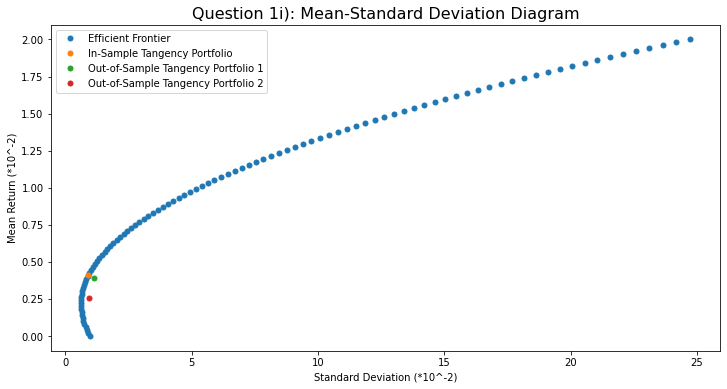

In [ ]:
odd = sheet1.iloc[::2]
even = sheet1.iloc[1:-1:2]
# Tangency Portfolio 1
R_even = even.mean()
V_even = even.cov()
V_even_inv = np.linalg.inv(V_even.values)
num = V_even_inv @ R_even
denom = onesT @ V_even_inv @ R_even
weight_tang_even = num / denom
R_odd = odd.mean()
Tan_odd = odd @ weight_tang_even
Tan_odd_SD = Tan_odd.std()
Tan_odd_Mean = Tan_odd.mean()
# Tangency Portfolio 2
R_odd = odd.mean()
V_odd = odd.cov()
V_odd_inv = np.linalg.inv(V_odd.values)
num = V_odd_inv @ R_odd
denom = onesT @ V_odd_inv @ R_odd
weight_tang_odd = num / denom
Tan_even = even @ weight_tang_odd
Tan_even_SD = Tan_even.std()
Tan_even_Mean = Tan_even.mean()
fig=plt.figure(figsize=(12,6))
plt.plot(y, x,'.',markersize=10, label = 'Efficient Frontier')
plt.plot(Tan_SD*100, Tan_Mean*100, '.', markersize=10, label = 'In-Sample Tangency Portfolio')
plt.plot(Tan_odd_SD*100, Tan_odd_Mean*100, '.', markersize=10, label = 'Out-of-Sample Tangency Portfolio 1')
plt.plot(Tan_even_SD*100, Tan_even_Mean*100, '.', markersize=10, label = 'Out-of-Sample Tangency Portfolio 2')
plt.plot()
plt.xlabel('Standard Deviation (*10^-2)')
plt.ylabel('Mean Return (*10^-2)');
plt.title('Question 1i): Mean-Standard Deviation Diagram', fontsize=16)
plt.legend()

We can see from the graph that the two out-of-sample tangency portfolio points are inside of the efficient frontier and are very close to each other. 

Similarly, the two out-of-sample tangency portfolio points are also quite close to the in-sample tangency portoflio point which lie directly on the efficient frontier. Therefore, using the out-of-sample data, we can get quite close to the ex post optimal efficient frontier.

##j)	Examine the commonality among the value and momentum portfolios across markets and asset classes more formally. Compute the correlation matrix among the value and momentum factors across the U.S., U.K., Europe, and Japan stock markets, country equity indexes, commodities, government bonds, and currencies.  Do the correlations surprise you?  Does this correlation structure help point you to a risk-based explanation for value and momentum or a behavioral one?  What else might account for this correlation structure?

Each strategy/factor is correlated across markets and asset classes. Value strategies are correlated with other value strategies in other markets and asset classes and the same for momentum strategies (e.g. momentum in currencies is correlated to momentum in commodities and momentum in the U.K market is correlated to momentum in the U.S. market). 

The covariance and negative correlation of momentum to value also crosses many asset classes and markets. Value and momentum always move in opposite directions whether it is in the same market/asset class or across markets/asset classes. 

Regarding the correlation structure of value and momentum across markets and asset classes, there could be both a risk-based explanation and a behavioral explanation. Fama and French would say that the correlation structure and common covariance of value and momentum across asset classes is due to risk. On the other hand, a behaviorists would say that human biases generate value and momentum and that this trend exists in various asset classes and markets.  it is due to the biases that people have that maybe generate value and momentum also exist across other asset classes and markets. 

##k)	Now, run a time-series regression test of each factor’s returns in each market on a volatility-weighted average of all other markets (e.g., US equity value factor on the average of value factors in all other markets plus the momentum factor’s returns across all other markets; then repeat in turn for each market). What do the alphas, and R-squares look like across markets? Plot in a graph the actual average return of each strategy against the predicted expected return of each strategy from the other markets/asset classes. Can you perform the GRS F-test here on the joint significance of the alphas?  Why or why not?

In [ ]:
sheet1 = pd.read_excel("Problem_Set9.xls", sheet_name="Value and momentum factors", skiprows=4, index_col=None, usecols="A:Q", na_values=-999)
sheet1 = sheet1.set_index("DATE")#[138:]
value = sheet1[['VAL^US','VAL^UK','VAL^EU','VAL^JP','VAL^EQ','VAL^FX','VAL^FI','VAL^CM']]
mom = sheet1[['MOM^US','MOM^UK','MOM^EU','MOM^JP','MOM^EQ','MOM^FX','MOM^FI','MOM^CM']]
alpha = []
r2 = []
alpha2 = []
r2_2 = []
pred1 = []
pred2 = []
for v,m in zip(value.columns,mom.columns):
  temp_v = np.std(value.loc[:, value.columns != v])
  temp_m = np.std(mom.loc[:, mom.columns != m])
  weight_v = (1/temp_v) / (1/np.sum(temp_v))
  weight_m =  (1/temp_m) / (1/np.sum(temp_m))
  col_temp_v = value.loc[:, value.columns != v]
  col_temp_m = mom.loc[:, mom.columns != v]
  weighted_col_v = col_temp_v * weight_v
  weighted_col_m = col_temp_m * weight_m
  # import pdb; pdb.set_trace()
  x = np.column_stack((weighted_col_v, weighted_col_m))  
  x = sm.add_constant(x, prepend=True) 
  x = x[:,~np.all(np.isnan(x), axis=0)]
  # try:
  # import pdb; pdb.set_trace()
  mod = sm.OLS(value[v], x, missing = 'drop').fit()
  alpha.append(mod.params[0])
  r2.append(mod.rsquared)
  pred1.append(np.mean(mod.predict()))
  mod2 = sm.OLS(mom[m], x, missing = 'drop').fit()
  alpha2.append(mod2.params[0])
  r2_2.append(mod2.rsquared)
  pred2.append(np.mean(mod2.predict()))
  # predictions = results.predict(data[half:])
  # except ValueError:  #raised if `y` is empty.
  #   pass
r_square = r2 + r2_2
alpha = alpha + alpha2
pred = pred1+pred2
cols = ['VAL^US','VAL^UK','VAL^EU','VAL^JP','VAL^EQ','VAL^FX','VAL^FI','VAL^CM','MOM^US','MOM^UK','MOM^EU','MOM^JP','MOM^EQ','MOM^FX','MOM^FI','MOM^CM']
gt = np.mean(sheet1,axis = 0)
k_dt = pd.DataFrame({'r_squared': r_square, 'alpha': alpha, 'pred_avg' : pred, 'groundtruth_avg': gt})
k_dt.index = cols
k_dt

,r_squared,alpha,pred_avg,groundtruth_avg
VAL^US,0.564504,-0.000588,0.002141,0.002706
VAL^UK,0.559028,0.000675,0.003228,0.006080
VAL^EU,0.631879,0.000943,0.002358,0.002796
VAL^JP,0.284989,0.004440,0.007445,0.006773
VAL^EQ,0.256134,0.002342,0.002489,0.002604
VAL^FX,0.135266,0.001870,0.002158,0.007499
VAL^FI,0.051943,0.001232,0.000678,0.007581
VAL^CM,0.091579,0.004221,0.003272,0.001965
MOM^US,0.575835,-0.000374,0.004683,0.002932
MOM^UK,0.655132,0.002776,0.008031,0.005106


Text(0.5, 1.0, 'Question 1k): Predicted vs Actual Average')

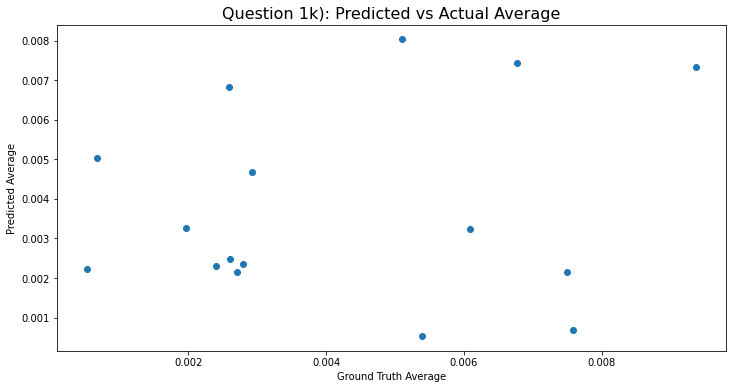

In [ ]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(12,6))
plt.scatter(gt, pred)
plt.xlabel('Ground Truth Average')
plt.ylabel('Predicted Average');
plt.title('Question 1k): Predicted vs Actual Average', fontsize=16)

In part B we saw that value and momentum have different effects across asset classes and markets, therefore we likely should not be able to perform a GRS test on the alphas here.

## l)	Using all the value and momentum portfolios run time series regressions for each portfolio and compute the GRS F-test for the joint significance of the alphas using the following factor models:

Report the individual alphas and R-squares from each regression as well.

 

### Model 1) CAPM using RMRF as single factor


In [ ]:
def GRS_test(x,y):
  alpha = []
  beta = []
  eps = []
  rsquare = []

  for i in y.columns:
    y_in = y[i]
    mod = sm.OLS(list(y_in),x,missing = 'drop').fit()
    alpha.append(mod.params[0])
    beta.append(mod.params[1])
    eps.append(mod.resid)
    rsquare.append(mod.rsquared)

  T = y.shape[0]
  N = y.shape[1]

  eps_df = pd.DataFrame(eps).T
  var_cov = eps_df.cov()

  # create Rm column in rm_rf
  FF['RM'] = FF['Mkt-RF'] + FF['RF']

  F = ((T-N-1)/N)* ((alpha @ np.linalg.inv(var_cov) @ np.transpose(alpha)) / (1+(FF['RM'][0:1069].mean()/FF['RM'][0:1069].std())**2))
  p_value = f.sf(F, N, T-N-1)
  print("F statistic: ", F, "p value: ", p_value)

  coeff_summary = pd.DataFrame({'portfolios':y.columns, 'alpha': alpha, 'beta': beta, 'r-square': rsquare})
  return coeff_summary

In [ ]:
# Model 1
sheet1 = pd.read_excel("Problem_Set9.xls", sheet_name="Value and momentum factors", skiprows=4, index_col=None, usecols="A:Q")
sheet1 = sheet1.set_index("DATE")
# sheet1['RF'] = FF.iloc[546:,:]['RF'].values
y = pd.DataFrame()
for col in sheet1.columns[0:16]:
  y[col] =  sheet1[col]# - sheet1['RF']

x = sm.add_constant(FF.iloc[546:,:]['Mkt-RF'])

y.index = x.index
GRS_test(x,y)

F statistic:  8.895433187311951 p value:  2.2291125735800604e-19


,portfolios,alpha,beta,r-square
0,VAL^US,0.003934,-0.002328,0.058853
1,MOM^US,0.006357,-0.000525,0.002681
2,VAL^UK,0.002595,0.000319,0.001212
3,MOM^UK,0.007334,-0.001058,0.012494
4,VAL^EU,0.002231,0.000591,0.007596
5,MOM^EU,0.008293,-0.001353,0.027307
6,VAL^JP,0.008167,-0.000928,0.010506
7,MOM^JP,0.002192,-0.000388,0.001462
8,VAL^EQ,0.002742,0.000307,0.002626
9,MOM^EQ,0.005125,-0.000031,0.000018


Since $p = 0 < 0.05$, we reject the null hypothesis that the $\alpha$ values are 0, which means that the returns could not be entirely explained by the market portfolio proxy - in this case the excess market return (Rm - Rf). In other words, the market portfolio proxy for the test is not mean-variance efficient.


###  Model 2) Fama-French 4-factor model:  RMRF, SMB, HML, UMD

In [ ]:
x = sm.add_constant(FF.iloc[546:,:][['Mkt-RF','SMB','HML','UMD']])
GRS_test(x,y)

F statistic:  6.285562678488237 p value:  6.902157726028328e-13


,portfolios,alpha,beta,r-square
0,VAL^US,0.002569,-0.000468,0.789674
1,MOM^US,-0.000706,0.000118,0.888535
2,VAL^UK,0.002248,0.001295,0.351986
3,MOM^UK,0.003835,-0.001041,0.351427
4,VAL^EU,0.002110,0.001090,0.370581
5,MOM^EU,0.005160,-0.001094,0.347535
6,VAL^JP,0.007734,-0.000233,0.149026
7,MOM^JP,0.000412,-0.000501,0.095279
8,VAL^EQ,0.002653,0.000427,0.043021
9,MOM^EQ,0.002823,0.000283,0.119999


Since $p = 0 < 0.05$, we reject the null hypothesis that the $\alpha$ values are 0, which means that the returns could not be entirely explained by the market portfolio proxy - in this case the excess market return (Rm - Rf), SMB, HML, UMD.

### Model 3) Asness-Moskowitz-Pedersen 3-factor model:  RMRF, 			VALeverywhere, MOMeverywhere

In [ ]:
MOM_everywhere = MOMeverywhere['MOM Factor']
VAL_everywhere = VALeverywhere['VAL Factor']

x = sm.add_constant(FF.iloc[546:,:]['Mkt-RF'])
MOM_everywhere.index = x.index
VAL_everywhere.index = x.index
x['MOM_everwhere'] = MOM_everywhere
x['VAL_everywhere'] = VAL_everywhere

GRS_test(x,y)

F statistic:  1.753272533400046 p value:  0.03451541849862732


,portfolios,alpha,beta,r-square
0,VAL^US,-0.000332,-0.002102,0.495085
1,MOM^US,0.001578,-0.000113,0.510929
2,VAL^UK,-0.002755,0.000562,0.575412
3,MOM^UK,0.002275,-0.000628,0.559496
4,VAL^EU,-0.001502,0.000743,0.627405
5,MOM^EU,0.001654,-0.000856,0.636788
6,VAL^JP,0.003255,-0.000675,0.382402
7,MOM^JP,-0.001734,-0.000079,0.275450
8,VAL^EQ,0.000365,0.000450,0.217516
9,MOM^EQ,-0.000383,0.000355,0.415908


Since $p = 0.03 < 0.05$, we reject the null hypothesis that the $\alpha$ values are 0, which means that the returns could not be entirely explained by RMRF,		VALeverywhere, MOMeverywhere.

###   Model 4) Asness-Moskowitz-Pedersen 3-factor model + TSMOM 


In [ ]:
x4 = x.iloc[156:,:]
x4['TSMOM'] = TSMOM['TSMOM']
temp_tsmom = TSMOM['TSMOM']
temp_tsmom.index = x4.index
x4['TSMOM'] =temp_tsmom # 371 rows × 5 columns

y4 = y.iloc[156:,:]
y4.index = x4.index
GRS_test(x4,y4)

F statistic:  13.331374567820761 p value:  8.032467923669349e-28


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,portfolios,alpha,beta,r-square
0,VAL^US,-0.003220,-0.002051,0.565562
1,MOM^US,0.002223,0.000188,0.596159
2,VAL^UK,-0.002676,0.000349,0.600798
3,MOM^UK,0.004793,-0.000430,0.664800
4,VAL^EU,-0.002829,0.000592,0.678008
5,MOM^EU,0.001650,-0.001049,0.722291
6,VAL^JP,0.003587,-0.000687,0.400418
7,MOM^JP,0.000058,0.000126,0.334526
8,VAL^EQ,0.000137,0.000596,0.232080
9,MOM^EQ,0.000478,0.000271,0.407654


###  Model 5) Asness-Moskowitz-Pedersen 3-factor model + TSMOM +LTREV+STR

In [ ]:
x4['LTREV'] = FF.iloc[702:,:]['LTREV']
x4['STREV'] = FF.iloc[702:,:]['STREV']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
GRS_test(x4,y4)

F statistic:  1.8056058379170399 p value:  0.0289892242856935


,portfolios,alpha,beta,r-square
0,VAL^US,-0.003307,-0.002227,0.568856
1,MOM^US,0.002568,0.000442,0.624100
2,VAL^UK,-0.002678,0.000397,0.601068
3,MOM^UK,0.004813,-0.000604,0.667807
4,VAL^EU,-0.002799,0.000543,0.679552
5,MOM^EU,0.001508,-0.001143,0.729514
6,VAL^JP,0.003442,-0.000621,0.410718
7,MOM^JP,0.000183,0.000058,0.340053
8,VAL^EQ,0.000165,0.000515,0.235709
9,MOM^EQ,0.000449,0.000103,0.412209


Which model performs the best at pricing the value and momentum portfolios and why? (Take into account both the alphas and the R-squares when making this assessment). Why are you able to run the GRS F-test here for these models?

We can see that the last model, Asness-Moskowitz-Pedersen 3-factor + TSMOM + LTREV + STREV, performs the best at pricing the value and momentum portfolios across the board, with consistently high R-squared and very low $\alpha$ values. 

# Part 2:  MOM vs. TSMOM
Now compare the MOM factor returns in equity index futures, currencies, fixed income, and commodities vs. TSMOM in each of these markets.


## m)	Design a test to see if MOM captures TSMOM and vice versa. Run that test and show your results and interpret the findings. What do you conclude?


In [ ]:
# Seperate momentum from sheet1
MOM_fullset = assets[['MOM^EQ','MOM^FX','MOM^FI','MOM^CM']]
MOM = MOM_fullset.iloc[156:,] # index concensus to TSMOM

def corr(col1, col2):
    mean1, mean2 = col1.mean(), col2.mean()
    std1, std2 = col1.std(), col2.std()
    corr = ((col1 * col2).mean()-mean1 * mean2)/(std1 * std2)
    return corr
print("Correlation coefficients of EQ, FX, FI, CM between MOM and TSMOM are", \
      round(corr(MOM['MOM^EQ'],TSMOM['TSMOM^EQ']),2), round(corr(MOM['MOM^FX'],TSMOM['TSMOM^FX']),2), \
      round(corr(MOM['MOM^FI'],TSMOM['TSMOM^FI']),2), round(corr(MOM['MOM^CM'],TSMOM['TSMOM^CM']),2), "respectively.")

Correlation coefficients of EQ, FX, FI, CM between MOM and TSMOM are 0.35 0.7 0.43 0.7 respectively.


In [ ]:
x = sm.add_constant(TSMOM.iloc[:,1:5]) 
mod1 = sm.OLS(TSMOM.iloc[:,0], x).fit()
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  TSMOM   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     8408.
Date:                Tue, 10 Nov 2020   Prob (F-statistic):               0.00
Time:                        16:22:32   Log-Likelihood:                 1552.8
No. Observations:                 371   AIC:                            -3096.
Df Residuals:                     366   BIC:                            -3076.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.000      0.523      0.601      -0.000       0.001
TSMOM^CM       0.4154      0.005     88.447      0.000       0.406       0.425
TSMOM^EQ       0.1659      0.003     65.934      0.000       0.161       0.171
TSMOM^FI       0.1703      0.002     73.422      0.000       0.166       0.175
TSMOM^FX       0.2399      0.004     64.557      0.000       0.233       0.247
==============================================================================
Omnibus:                       88.529   Durbin-Watson:                   1.874
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              597.301
Skew:                           0.805   Prob(JB):                    1.98e-130
Kurtosis:                       9.004   Cond. No.                         24.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
x = sm.add_constant(MOM)
mod2 = sm.OLS(list(TSMOM.iloc[:,0]), x).fit()
mod2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     83.35
Date:                Tue, 10 Nov 2020   Prob (F-statistic):           3.02e-50
Time:                        16:22:32   Log-Likelihood:                 832.34
No. Observations:                 371   AIC:                            -1655.
Df Residuals:                     366   BIC:                            -1635.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0090      0.001      6.613      0.000       0.006       0.012
MOM^EQ         0.2727      0.044      6.200      0.000       0.186       0.359
MOM^FX         0.5002      0.052      9.528      0.000       0.397       0.603
MOM^FI         0.5093      0.107      4.773      0.000       0.299       0.719
MOM^CM         0.2261      0.025      9.016      0.000       0.177       0.275
==============================================================================
Omnibus:                       29.161   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.202
Skew:                           0.511   Prob(JB):                     3.41e-11
Kurtosis:                       4.440   Cond. No.                         79.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We first computed the Pearson correlation between TSMOM and MOM. The correlation is from 0.4 - 0.7.

Then use the $R^2$ from the linear model $$\text{TSMOM} = \beta0 + \beta1 \cdot \text{TSMOM^EQ} + \beta2 \cdot \text{TSMOM^FX} + \beta3 \cdot \text{TSMOM^FI} + \beta4 \cdot \text{TSMOM^CM}$$ as baseline, compute the $R^2$ from $$\text{TSMOM} =  \beta0 + \beta1 \cdot \text{MOM^EQ} + \beta2 \cdot \text{MOM^FX} + \beta3 \cdot \text{MOM^FI} + \beta4 \cdot \text{MOM^CM}$$. The baseline $R^2$ is 0.989, while the $R^2$ using MOM variables to fit TSMOM is 0.477. We conclude that MOM can't capture TSMOM. 

# Part 3:  Hedge funds
The hedge fund indices are long only portfolios so you will need to subtract off a riskless interest rate. Just use the U.S. T-bill rate which has been provided for you in the last column of this spreadsheet.

## n)	Using the hedge fund portfolios run time series regressions for each portfolio and compute the GRS F-test for the joint significance of the alphas using the following factor models:


Report the individual alphas and R-squares from each regression as well.

Which model performs the best at pricing the hedge fund portfolios and why?  (Take into account both the alphas and the R-squares when making this assessment)
What factors do the various hedge fund strategies load on?  Do these make sense? Is there anything surprising?
What does the loading on the lagged market return tell you?



### Model 1) CAPM using RMRF as single factor


In [ ]:
dt_n = HRFI.iloc[0:311,:]
dt_n.index = FF.iloc[762:,:]['RF'].index

dt_n['RF'] = FF.iloc[762:,:]['RF']

y = pd.DataFrame()
for col in dt_n.columns[0:10]:
  y[col] =  dt_n[col] - dt_n['RF'] *0.001

x = sm.add_constant(FF.iloc[762:,:]['Mkt-RF'])

y.index = x.index
GRS_test(x,y)

F statistic:  21.54411565506102 p value:  3.9346649851050664e-30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,portfolios,alpha,beta,r-square
0,Convert Arb,0.005220,0.002013,0.227519
1,Ded Short Bias,0.005540,-0.009374,0.628585
2,Emerging Markets,0.005602,0.005988,0.429862
3,Eq Mkt Neutral,0.004761,0.000559,0.073389
4,Event Driven,0.006387,0.003277,0.546940
5,FI Rel Val,0.006537,0.001480,0.273078
6,Fund Returns,0.005908,0.003544,0.624864
7,Global Macro,0.007616,0.001692,0.121649
8,L/S Equity,0.006572,0.004650,0.616295
9,Managed Futures,0.006739,0.002001,0.166139



### Model 2) CAPM using RMRF and RMRF(lagged a month) 



In [ ]:
x['lagged_Mkt-RF'] = x['Mkt-RF'].shift(1)
x.iloc[0,2] = 1.16
GRS_test(x,y)

F statistic:  21.084070380884985 p value:  1.436748983721321e-29


,portfolios,alpha,beta,r-square
0,Convert Arb,0.004656,0.001942,0.282063
1,Ded Short Bias,0.005652,-0.009360,0.628858
2,Emerging Markets,0.004887,0.005898,0.448541
3,Eq Mkt Neutral,0.004722,0.000554,0.074513
4,Event Driven,0.005752,0.003197,0.609559
5,FI Rel Val,0.006132,0.001428,0.335699
6,Fund Returns,0.005477,0.003490,0.653013
7,Global Macro,0.007474,0.001674,0.124276
8,L/S Equity,0.006173,0.004600,0.630117
9,Managed Futures,0.006743,0.002001,0.166141


### Model 3) Fama-French 4-factor model:  RMRF, RMRF(lag), SMB, HML, UMD


In [ ]:
x['SBM'] = FF.iloc[762:,:]['SMB']
x['HML'] = FF.iloc[762:,:]['HML']
x['UMD'] = FF.iloc[762:,:]['UMD']
GRS_test(x,y)

F statistic:  19.838713022224695 p value:  5.0505655773976685e-28


,portfolios,alpha,beta,r-square
0,Convert Arb,0.004798,0.001890,0.297749
1,Ded Short Bias,0.004998,-0.007947,0.793222
2,Emerging Markets,0.004479,0.005787,0.466955
3,Eq Mkt Neutral,0.003789,0.000904,0.321332
4,Event Driven,0.005452,0.003116,0.668836
5,FI Rel Val,0.006033,0.001436,0.363582
6,Fund Returns,0.005149,0.003326,0.731939
7,Global Macro,0.006560,0.001863,0.202565
8,L/S Equity,0.005586,0.004424,0.723054
9,Managed Futures,0.006412,0.001953,0.258266



### Model 4) Asness-Moskowitz-Pedersen 3-factor model:  RMRF, RMRF(lag), VALeverywhere, MOMeverywhere


In [ ]:
del x['SBM'], x['HML'], x['UMD']
mom = pd.DataFrame(MOM_everywhere)
val = pd.DataFrame(VAL_everywhere)
x['MOM_everwhere'] = mom.iloc[216:,:]
x['VAL_everywhere'] = val.iloc[216:,:]
GRS_test(x,y)

F statistic:  17.09487100967918 p value:  1.7177268173777632e-24


,portfolios,alpha,beta,r-square
0,Convert Arb,0.003994,0.002026,0.293960
1,Ded Short Bias,0.002533,-0.009023,0.685000
2,Emerging Markets,0.003358,0.006152,0.457533
3,Eq Mkt Neutral,0.003466,0.000777,0.227471
4,Event Driven,0.004726,0.003356,0.625544
5,FI Rel Val,0.005285,0.001548,0.366837
6,Fund Returns,0.004858,0.003630,0.680078
7,Global Macro,0.006019,0.001978,0.208381
8,L/S Equity,0.005525,0.004763,0.658430
9,Managed Futures,0.006980,0.002056,0.244773



### Model 5) Asness-Moskowitz-Pedersen 3-factor model + TSMOM 


In [ ]:
temp_tsmom = TSMOM.iloc[60:,:]
temp_tsmom.index = x.index
x['TSMOM'] = temp_tsmom['TSMOM']
GRS_test(x,y)

F statistic:  15.702290418578041 p value:  1.2492944489489963e-22


,portfolios,alpha,beta,r-square
0,Convert Arb,0.004009,0.002027,0.293971
1,Ded Short Bias,0.002373,-0.009032,0.685150
2,Emerging Markets,0.003971,0.006186,0.461249
3,Eq Mkt Neutral,0.003483,0.000778,0.227529
4,Event Driven,0.004867,0.003364,0.626379
5,FI Rel Val,0.005484,0.001559,0.370888
6,Fund Returns,0.004747,0.003624,0.680586
7,Global Macro,0.004490,0.001892,0.290095
8,L/S Equity,0.005538,0.004764,0.658434
9,Managed Futures,0.004995,0.001945,0.379392



### Model 6) Asness-Moskowitz-Pedersen 3-factor model + TSMOM +LTREV+STR


In [ ]:
x['LTREV'] = FF.iloc[762:,:]['LTREV']
x['STREV'] = FF.iloc[762:,:]['STREV']
GRS_test(x,y)

F statistic:  15.73141451308876 p value:  1.1408674288299388e-22


,portfolios,alpha,beta,r-square
0,Convert Arb,0.004021,0.001961,0.296336
1,Ded Short Bias,0.002450,-0.008836,0.700394
2,Emerging Markets,0.003943,0.006188,0.463316
3,Eq Mkt Neutral,0.003464,0.000870,0.249262
4,Event Driven,0.004852,0.003280,0.634280
5,FI Rel Val,0.005488,0.001510,0.373095
6,Fund Returns,0.004722,0.003644,0.686430
7,Global Macro,0.004452,0.002044,0.303590
8,L/S Equity,0.005483,0.004848,0.674068
9,Managed Futures,0.004966,0.002142,0.392989



### Model 7) Asness-Moskowitz-Pedersen 3-factor model + TSMOM +LTREV+STR+BAB+Qual/Def+Carry

In [ ]:
x['BAB'] = CBQ.iloc[762:,:]['BAB']
x['Defensive/Quality'] = CBQ.iloc[762:,:]['Defensive/Quality']
x['Carry'] = CBQ.iloc[762:,:]['Carry']
GRS_test(x, y)

F statistic:  19.35073180976351 p value:  2.082567691745896e-27


,portfolios,alpha,beta,r-square
0,Convert Arb,0.003435,0.002083,0.417224
1,Ded Short Bias,-0.000809,-0.009147,0.737635
2,Emerging Markets,0.002423,0.006030,0.485567
3,Eq Mkt Neutral,0.003672,0.000995,0.293110
4,Event Driven,0.004813,0.003405,0.676430
5,FI Rel Val,0.005329,0.001628,0.462208
6,Fund Returns,0.004903,0.003723,0.711590
7,Global Macro,0.004410,0.002151,0.316679
8,L/S Equity,0.006148,0.004971,0.698480
9,Managed Futures,0.005972,0.002257,0.410569


Model 5 may be best at predicting returns, evidenced by its low GRS F-test statistic and relatively low p-value of 1.2. TSOM is a easily implementable factor that can capture hedge fund returns, as found in Fung and Hsieh (2001). Each factor contributes to the outcome variable. BAB+Qual/Def+Carry are good additions to the model and model 7 gives the largest R^2. However, we also need to consider the overfitting problem.  

# Part 4:  Putting it all together
Using the following factors:  RMRF, SMB, VALeverywhere, MOMeverywhere, BAB, Qual/Defensive, Carry, STREV, LTREV
 





## o)	Calculate the in-sample tangency portfolio of all the factors and plot the efficient frontier of all the factors.  What is the Sharpe ratio of this tangency portfolio and what weights are placed on the factors?


The fit coefficients are a = 3.3227, b = -1.7477 c = 0.8736
       2
3.323 x - 1.748 x + 0.8736


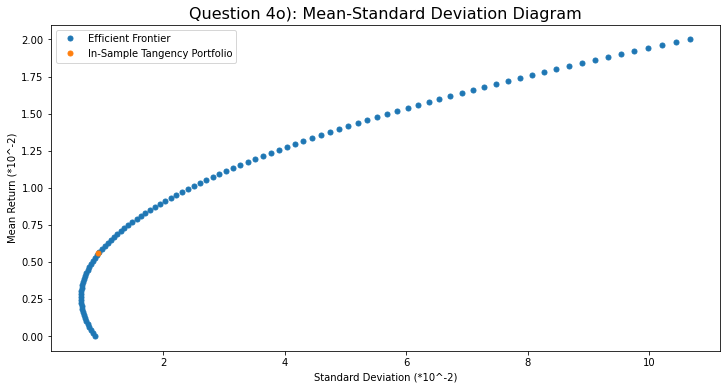

In [ ]:
All_Factors = FF[['Mkt-RF', 'SMB', 'STREV', 'LTREV']][546:]
VAL_Factor.index = All_Factors.index
MOM_Factor.index = All_Factors.index
All_Factors = pd.concat([All_Factors, VAL_Factor, MOM_Factor, CBQ[546:]], axis = 1)

R_all = All_Factors.mean()
V_all = All_Factors.cov()
V_all_inv = np.linalg.inv(V_all)
ones = np.transpose([1]*len(All_Factors.columns.tolist()))
onesT = np.transpose(ones)
# Tangency Portfolio
num = V_all_inv @ R_all
denom = onesT @ V_all_inv @ R_all
weight_all_tang = num / denom
Tan_all = All_Factors @ weight_all_tang
Tan_all_SD = Tan_all.std()
Tan_all_Mean = Tan_all.mean()
# MVP
num = V_all_inv @ ones
denom = onesT @ V_all_inv @ ones
weight_all_MVP = num / denom
MVP_all = All_Factors @ weight_all_MVP
MVP_all_SD = MVP_all.std()
MVP_all_Mean = MVP_all.mean()

df = pd.DataFrame({'x':[MVP_all_SD*100, Tan_all_SD*100, Tan_all_SD*100], 
                  'y':[MVP_all_Mean*100, Tan_all_Mean*100, 100*(Tan_all_Mean - 2*(Tan_all_Mean - MVP_all_Mean))]})

fit = np.polyfit(df['y'], df['x'], 2)
equation = np.poly1d(fit)
print ("The fit coefficients are a = {0:.4f}, b = {1:.4f} c = {2:.4f}".format(*fit))
print (equation)

x = np.linspace(2, 0, num=100)
y = 3.323 * x **2 - 1.748 * x + 0.8736
fig=plt.figure(figsize=(12,6))
plt.plot(y, x,'.',markersize=10, label = 'Efficient Frontier')
plt.plot(Tan_all_SD*100, Tan_all_Mean*100, '.', markersize=10, label = 'In-Sample Tangency Portfolio')
plt.plot()
plt.xlabel('Standard Deviation (*10^-2)')
plt.ylabel('Mean Return (*10^-2)');
plt.title('Question 4o): Mean-Standard Deviation Diagram', fontsize=16)
plt.legend()

In [ ]:
print('The Sharpe Ratio of this tangency portfolio is ', round(Tan_all_Mean / Tan_all_SD * np.sqrt(12), 2))
print('The weights for tangency portfolio with RMRF, SMB, VALeverywhere, MOMeverywhere, BAB, Qaul/Defensive, Carry, STREV, LTREV are ', \
      weight_all_tang)

The Sharpe Ratio of this tangency portfolio is  2.07
The weights for tangency portfolio with RMRF, SMB, VALeverywhere, MOMeverywhere, BAB, Qaul/Defensive, Carry, STREV, LTREV are  [ 1.00554896e-04  7.97449090e-04  6.07776178e-04 -9.98433847e-06
  4.21792243e-01  3.44116472e-01 -2.93261535e-02  1.38694408e-01
  1.23227234e-01]


We can see the sharpe ratio using all these factors is exceptionally high, at 2.07. Additionally, the weight for BAB, Qual/Defensive, Carry, STREV, and LTREV seem to be much higher than RMRF, SMB, VALeverywhere, and MOMeverywhere.

## p)	Now, repeat the tangency portfolio exercise above using even months to compute tangency portfolio weights and then applied to odd-month returns and vice versa to generate an out-of-sample tangency portfolio of all the factor portfolios. Plot this on the efficient frontier you created in o). How different are the results? What is the Sharpe ratio and portfolio weights of this portfolio? How close do you get to the ex post optimal efficient frontier?

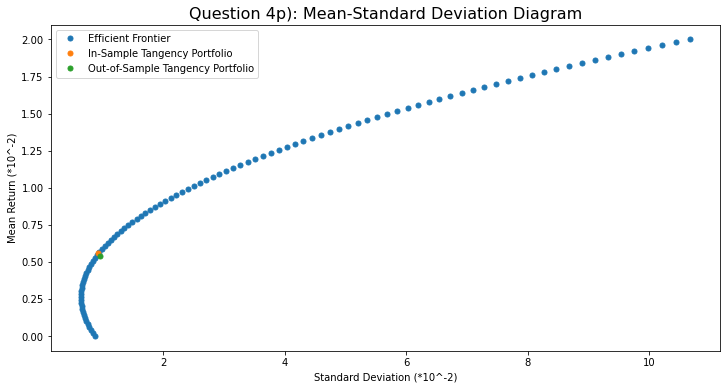

In [ ]:
all_odd = All_Factors.iloc[::2]
all_even = All_Factors.iloc[1:-1:2]
# Tangency Portfolio 1
R_all_even = all_even.mean()
V_all_even = all_even.cov()
V_all_even_inv = np.linalg.inv(V_all_even.values)
num = V_all_even_inv @ R_all_even
denom = onesT @ V_all_even_inv @ R_all_even
weight_all_tang_even = num / denom
Tan_all_odd = all_odd @ weight_all_tang_even
Tan_all_odd_SD = Tan_all_odd.std()
Tan_all_odd_Mean = Tan_all_odd.mean()
fig=plt.figure(figsize=(12,6))
plt.plot(y, x,'.',markersize=10, label = 'Efficient Frontier')
plt.plot(Tan_all_SD*100, Tan_all_Mean*100, '.', markersize=10, label = 'In-Sample Tangency Portfolio')
plt.plot(Tan_all_odd_SD*100, Tan_all_odd_Mean*100, '.', markersize=10, label = 'Out-of-Sample Tangency Portfolio')
plt.plot()
plt.xlabel('Standard Deviation (*10^-2)')
plt.ylabel('Mean Return (*10^-2)');
plt.title('Question 4p): Mean-Standard Deviation Diagram', fontsize=16)
plt.legend()

In [ ]:
print('The Sharpe Ratio of OOS tangency portfolio is ', round(Tan_all_odd_Mean / Tan_all_odd_SD * np.sqrt(12), 2))
print('The weights for the OOS tangency portfolio with RMRF, SMB, VALeverywhere, MOMeverywhere, BAB, Qaul/Defensive, Carry, STREV, LTREV are ', \
      weight_all_tang_even)

The Sharpe Ratio of OOS tangency portfolio is  1.95
The weights for the OOS tangency portfolio with RMRF, SMB, VALeverywhere, MOMeverywhere, BAB, Qaul/Defensive, Carry, STREV, LTREV are  [ 3.57927148e-04  5.20849944e-04  1.03611492e-04 -1.46979011e-04
  3.96076611e-01  3.93132195e-01 -9.20603328e-02  1.62633440e-01
  1.39382677e-01]


We can see graphically that the out-of-sample tangency portoflio point is extremely close to the in-sample point. 

The sharpe ratio using all these factors out-of-sample is still exceptionally high, at 1.95. Additionally, the weight for BAB, Qual/Defensive, Carry, STREV, and LTREV seem to be much higher than RMRF, SMB, VALeverywhere, and MOMeverywhere.

In this case, we're pretty much right on the ex post optimal efficient frontier.